<h1>Business Case</h1>

How can accident respose teams be best deployed? Every City has a limited amount of accident response resources 
including police, paramedics, and fire departments.  This analysis will help inform them about how to better manage 
staffing and general preparedness for accidents during different weather condidions.  Additionally it may help guide
infastructure decisions, what about these high level of accidents locations is causing the spike in accidents and if there is a way to fix
them.

In [1]:
!pip install folium

In [2]:
!conda install geopandas

Solving environment: done

# All requested packages already installed.



In [3]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import ibm_boto3
import folium

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_644dfceb6d68471ea20a550a2f41bc3b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='AhpqSjZNn_dHl3XHzzqe8-bp05Q74BVDiaUciCjYAsTD',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_644dfceb6d68471ea20a550a2f41bc3b.get_object(Bucket='course9capstone-donotdelete-pr-7ewgfktlgfywok',Key='DataCollisionsExample.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


<b> Data </b> 

The data can be seperated by severity with two values; 1 or 2.  after removing 'WEATHER' data that was listed as 
unkown ther are still 189592 samples, more than enough to provide a good picture of where and when accidents are 
occuring. 

In [4]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [5]:
df = df[['SEVERITYCODE', 'WEATHER', 'X', 'Y']]
df.head()

,SEVERITYCODE,WEATHER,X,Y
0,2,Overcast,-122.323148,47.703140
1,1,Raining,-122.347294,47.647172
2,1,Overcast,-122.334540,47.607871
3,1,Clear,-122.334803,47.604803
4,2,Raining,-122.306426,47.545739


There are 10 distinct weather condidions which may cause a confusing visual, the data may need to be
trimmed to only include the top 5 most common reported weather conditions during accident.

In [6]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [7]:
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

The data will be cleaned by removing all unknown and rarley reported weather condidions as that data is of no value for this analysis.  Then the data will be 
put through a density based clustering algorithm based on the latitude and logitude of the accident and visualized on
a map and labeled by weather condition.

In [8]:
#drop all unknow weather types
df.dropna(axis=0,how='any', subset=['WEATHER'], inplace=True)
#Remove the uncommen and un-usefull weather types
df.drop(df.loc[df['WEATHER']=='Other'].index, inplace=True)
df.drop(df.loc[df['WEATHER']=='Blowing Sand/Dirt'].index, inplace=True)
df.drop(df.loc[df['WEATHER']=='Severe Crosswind'].index, inplace=True)
df.drop(df.loc[df['WEATHER']=='Partly Cloudy'].index, inplace=True)
df.drop(df.loc[df['WEATHER']=='Unknown'].index, inplace=True)
df.shape[0]

173583

In [9]:
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Snowing                        907
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Name: WEATHER, dtype: int64

In [10]:
import matplotlib as plt
df.groupby(['WEATHER', 'SEVERITYCODE']).size().unstack().plot(kind='bar', stacked=True)

Because the density based clustering handles outliers there is no processing needed of the Latitude and longitude besides confirming that the values are not null.

In [11]:
df.isnull().sum()

SEVERITYCODE       0
WEATHER            0
X               3914
Y               3914
dtype: int64

In [12]:
#Drop the null values in the latitude and longitude columns
df.dropna(axis=0,how='any', subset=['X', 'Y'], inplace=True)

In [13]:
#confirm that the 
df.shape

(169669, 4)

In [14]:
df.isnull().sum()


SEVERITYCODE    0
WEATHER         0
X               0
Y               0
dtype: int64

After this data has been processed by a Density based clasification algorithm the Seattle area will have 'hot spots' acidents labeled by severity and weather,  for instance when it rains they will be able to predict 
where the majority of accidents and deploy assets accordingly.  If a snow storm is on its way, they will know how to properly schedule employees.

In [15]:
#Injurys vs Property Damage dataframes 
dfInjury = df.loc[df['SEVERITYCODE']==2]
dfProp = df.loc[df['SEVERITYCODE']==1]

dfInjury.head()

,SEVERITYCODE,WEATHER,X,Y
0,2,Overcast,-122.323148,47.703140
4,2,Raining,-122.306426,47.545739
7,2,Clear,-122.320780,47.614076
9,2,Clear,-122.384700,47.528475
14,2,Clear,-122.317414,47.664028


In [16]:
#segment data based on weather conditions and severity to prepare for clustering
# Clear                       
# Raining                      
# Overcast                       
# Snowing                        
# Fog/Smog/Smoke                 
# Sleet/Hail/Freezing Rain       
dfc = df.loc[df['WEATHER'] == 'Clear']
dfr = df.loc[df['WEATHER'] == 'Raining']
dfo = df.loc[df['WEATHER'] == 'Overcast']
dfs = df.loc[df['WEATHER'] == 'Snowing']
dff = df.loc[df['WEATHER'] == 'Fog/Smog/Smoke']
dfh = df.loc[df['WEATHER'] == 'Sleet/Hail/Freezing Rain']

#Create a set of the training data
dft = [dfc, dfr, dfo, dfs, dff, dfh]
dfc.head()


,SEVERITYCODE,WEATHER,X,Y
3,1,Clear,-122.334803,47.604803
5,1,Clear,-122.387598,47.690575
7,2,Clear,-122.320780,47.614076
8,1,Clear,-122.335930,47.611904
9,2,Clear,-122.384700,47.528475


In [17]:
##############  Density Based Clustering for snowing conditions

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)

Clus_dataSet = dfs[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

#Severe clustered


# # Compute DBSCAN
db = DBSCAN(eps=5/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dfs["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
dfs.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(894, 5)

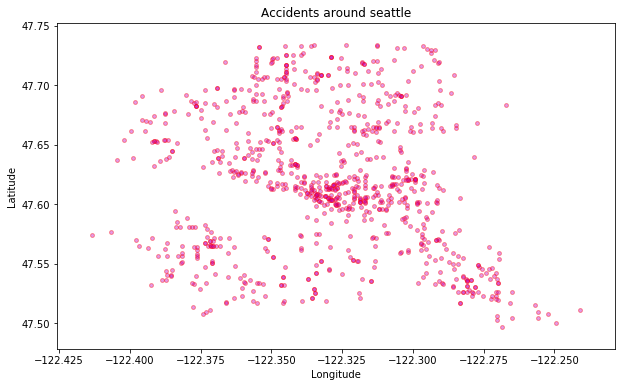

In [18]:
import matplotlib.cm as cm, matplotlib.font_manager as fm
from datetime import datetime as dt
from geopy.distance import great_circle


fig, ax = plt.pyplot.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(dfs['X'], dfs['Y'], c='m', edgecolor='r', alpha=.4, s=15)

ax.set_title('Accidents around seattle')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.pyplot.show()

In [19]:
coords = dfs[['Y', 'X']].as_matrix()

num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

Number of clusters: 20


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [20]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)


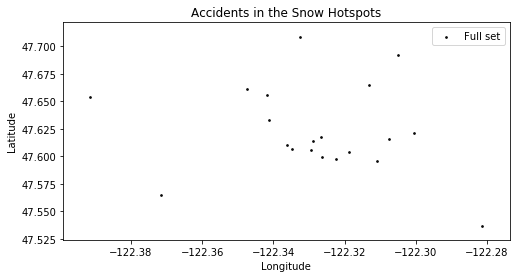

In [21]:
##CALCULATE CENTERMOSTPOINTS
centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

df = rep_points.apply(lambda row: dfs[(dfs['Y']==row['lat']) & (dfs['X']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.pyplot.subplots(figsize=[8, 4])
df_scatter = ax.scatter(df['X'], df['Y'], c='k', alpha=0.9, s=3)
ax.set_title('Accidents in the Snow Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.pyplot.show()

In [22]:
df.iloc[1]

SEVERITYCODE          1
WEATHER         Snowing
X              -122.341
Y                47.633
Clus_Db               1
Name: 1, dtype: object

In [23]:
import folium
# Make an empty map
snowM = folium.Map(location=[47.625,-122.34], zoom_start=10)###, tiles="Mapbox Bright"
 
# # Add marker one by one on the map
for i in range(1,len(df)):
   folium.CircleMarker(
      location=[df.iloc[i]['Y'], df.iloc[i]['X']],
      popup=df.iloc[i]['Clus_Db'],
#       radius=data.iloc[i]['value']*10000,
      radius= 5.0,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(snowM)
 

snowM

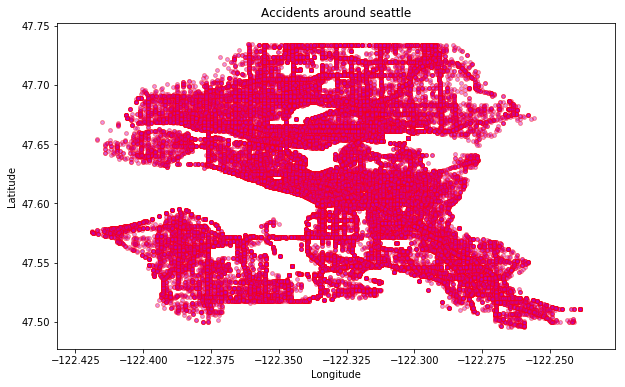

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Number of clusters: 10


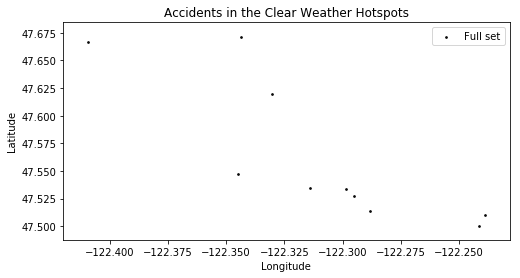

In [24]:
#######Clear weather data


Clus_dataSet = dfc[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)



# # Compute DBSCAN
db = DBSCAN(eps=10/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dfc["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


fig, ax = plt.pyplot.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(dfc['X'], dfc['Y'], c='m', edgecolor='r', alpha=.4, s=15)

ax.set_title('Accidents around seattle')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.pyplot.show()

coords = dfc[['Y', 'X']].as_matrix()
num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

df = rep_points.apply(lambda row: dfc[(dfc['Y']==row['lat']) & (dfc['X']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.pyplot.subplots(figsize=[8, 4])
df_scatter = ax.scatter(df['X'], df['Y'], c='k', alpha=0.9, s=3)
ax.set_title('Accidents in the Clear Weather Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.pyplot.show()


# Make an empty map
clearM = folium.Map(location=[47.625,-122.34], zoom_start=10)###, tiles="Mapbox Bright"
 
# # Add marker one by one on the map
for i in range(1,len(df)):
   folium.CircleMarker(
      location=[df.iloc[i]['Y'], df.iloc[i]['X']],
      popup=df.iloc[i]['Clus_Db'],
#       radius=data.iloc[i]['value']*10000,
      radius= 5.0,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(clearM)
 

clearM

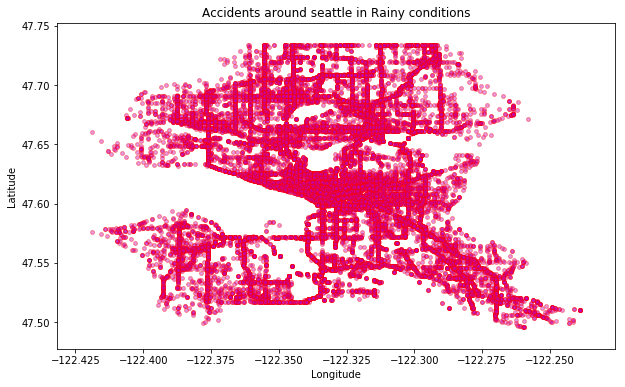

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Number of clusters: 15


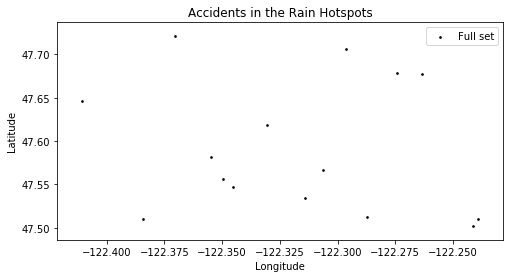

In [25]:
##########process the Rain dataFrame

Clus_dataSet = dfr[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)


# # Compute DBSCAN
db = DBSCAN(eps=10/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dfr["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


fig, ax = plt.pyplot.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(dfr['X'], dfr['Y'], c='m', edgecolor='r', alpha=.4, s=15)

ax.set_title('Accidents around seattle in Rainy conditions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.pyplot.show()

coords = dfr[['Y', 'X']].as_matrix()
# coords = dfr.values
num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()




df = rep_points.apply(lambda row: dfr[(dfr['Y']==row['lat']) & (dfr['X']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.pyplot.subplots(figsize=[8, 4])
df_scatter = ax.scatter(df['X'], df['Y'], c='k', alpha=0.9, s=3)
ax.set_title('Accidents in the Rain Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.pyplot.show()


# Make an empty map
rainM = folium.Map(location=[47.625,-122.34], zoom_start=10)###, tiles="Mapbox Bright"
 
# # Add marker one by one on the map
for i in range(0,len(df)):
   folium.CircleMarker(
      location=[df.iloc[i]['Y'], df.iloc[i]['X']],
      popup=df.iloc[i]['Clus_Db'],
      radius= 5.0, #make this varible with the amount of samples in the cluster
      color='yellow',
      fill=True,
      fill_color='yellow'
   ).add_to(rainM)
 

rainM

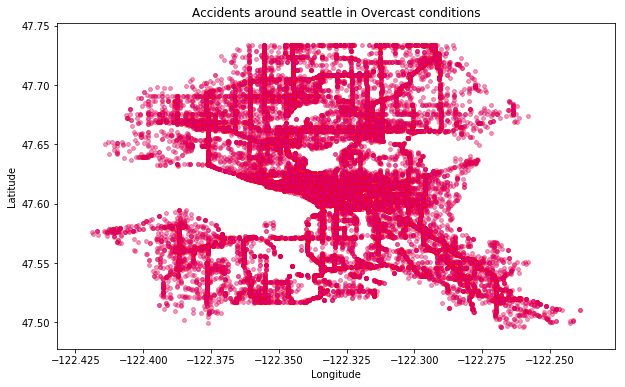

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Number of clusters: 13


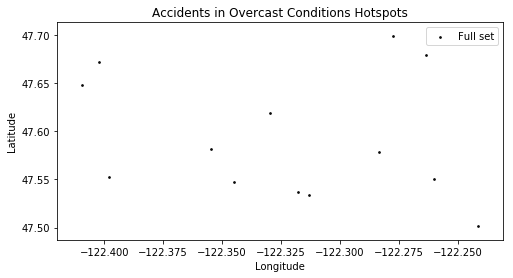

In [26]:
Clus_dataSet = dfo[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# # Compute DBSCAN
db = DBSCAN(eps=10/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dfo["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


fig, ax = plt.pyplot.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(dfo['X'], dfo['Y'], c='m', edgecolor='r', alpha=.4, s=15)

ax.set_title('Accidents around seattle in Overcast conditions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.pyplot.show()

coords = dfo[['Y', 'X']].as_matrix()
# coords = dfo.values
num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()


df = rep_points.apply(lambda row: dfo[(dfo['Y']==row['lat']) & (dfo['X']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.pyplot.subplots(figsize=[8, 4])
df_scatter = ax.scatter(df['X'], df['Y'], c='k', alpha=0.9, s=3)
ax.set_title('Accidents in Overcast Conditions Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.pyplot.show()


# Make an empty map
overM = folium.Map(location=[47.625,-122.34], zoom_start=10)###, tiles="Mapbox Bright"
 
# # Add marker one by one on the map
for i in range(1,len(df)):
   folium.CircleMarker(
      location=[df.iloc[i]['Y'], df.iloc[i]['X']],
      popup=df.iloc[i]['Clus_Db'],
      radius= 5.0, #make this varible with the amount of samples in the cluster
      color='purple',
      fill=True,
      fill_color='purple'
   ).add_to(overM)
 

overM

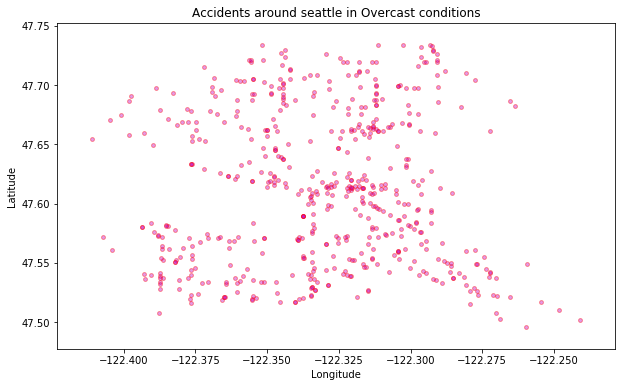

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Number of clusters: 3


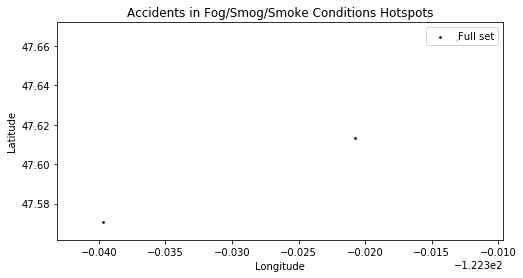

In [27]:
###################Fog/smog/smoke conditions data processing
Clus_dataSet = dff[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# # Compute DBSCAN
db = DBSCAN(eps=5/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dff["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


fig, ax = plt.pyplot.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(dff['X'], dff['Y'], c='m', edgecolor='r', alpha=.4, s=15)

ax.set_title('Accidents around seattle in Overcast conditions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.pyplot.show()

coords = dff[['Y', 'X']].as_matrix()
num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()


df = rep_points.apply(lambda row: dff[(dff['Y']==row['lat']) & (dff['X']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.pyplot.subplots(figsize=[8, 4])
df_scatter = ax.scatter(df['X'], df['Y'], c='k', alpha=0.9, s=3)
ax.set_title('Accidents in Fog/Smog/Smoke Conditions Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.pyplot.show()


# Make an empty map
fogM = folium.Map(location=[47.625,-122.34], zoom_start=10)###, tiles="Mapbox Bright"
 
# # Add marker one by one on the map
for i in range(1,len(df)):
   folium.CircleMarker(
      location=[df.iloc[i]['Y'], df.iloc[i]['X']],
      popup=df.iloc[i]['Clus_Db'],
      radius= 5.0, #make this varible with the amount of samples in the cluster
      color='black',
      fill=True,
      fill_color='black'
   ).add_to(fogM)
 

fogM

In [28]:
Clus_dataSet = dfInjury[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# # Compute DBSCAN
db = DBSCAN(eps=10/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dfInjury["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


coords = dfInjury[['Y', 'X']].as_matrix()
num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()


dfI = rep_points.apply(lambda row: dfInjury[(dfInjury['Y']==row['lat']) & (dfInjury['X']==row['lon'])].iloc[0], axis=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Number of clusters: 13


In [29]:
Clus_dataSet = dfProp[['X', 'Y']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# # Compute DBSCAN
db = DBSCAN(eps=10/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(Clus_dataSet))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dfProp["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


coords = dfProp[['Y', 'X']].as_matrix()
num_clusters = len(set(labels))
cluster_labels = db.labels_

clusters = pd.Series([coords[cluster_labels==n] for n in range(realClusterNum)])
print('Number of clusters:',realClusterNum)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()


dfP = rep_points.apply(lambda row: dfProp[(dfProp['Y']==row['lat']) & (dfProp['X']==row['lon'])].iloc[0], axis=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Number of clusters: 10


In [30]:
####### SEVERITY ANALYSIS MAP

# Make an empty map
severityM = folium.Map(location=[47.625,-122.34], zoom_start=10)###, tiles="Mapbox Bright"
 
# # Add marker one by one on the map 
for i in range(1,len(dfI)):
   folium.CircleMarker(
      location=[dfI.iloc[i]['Y'], dfI.iloc[i]['X']],
      popup=dfI.iloc[i]['Clus_Db'],
      radius= 5.0, #make this varible with the amount of samples in the cluster
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(severityM)

# # Add marker one by one on the map for property damage
for i in range(1,len(dfP)):
   folium.CircleMarker(
      location=[dfP.iloc[i]['Y'], dfP.iloc[i]['X']],
      popup=dfP.iloc[i]['Clus_Db'],
      radius= 5.0, #make this varible with the amount of samples in the cluster
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(severityM)

severityM
